<h1 style="text-align: center;">PPOL 5204 Final Project<br></h1>



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import randint, uniform

from sklearn import datasets
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay,
    precision_recall_curve, roc_auc_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

from sklearn.svm import SVC
import xgboost as xgb

from sklearn.inspection import permutation_importance

import shap

import lime
import lime.lime_tabular

from joblib import Parallel, delayed

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


In [2]:
# Load the road safety dataset
road_data = pd.read_csv('dft-road-casualty-statistics-casualty-provisional-mid-year-unvalidated-2023.csv')

In [8]:
road_data.head(10)

,collision_index,collision_year,collision_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,lsoa_of_casualty
0,2023010419171,2023,010419171,1,1,3,2,20,4,3,5,1,0,0,0,0,1,10,E01030370
1,2023010419183,2023,010419183,2,1,1,1,25,5,3,0,0,0,0,0,9,1,3,E01001546
2,2023010419183,2023,010419183,3,2,2,2,38,7,3,0,0,2,0,0,9,-1,5,-1
3,2023010419189,2023,010419189,1,1,1,1,50,8,3,0,0,0,0,0,9,1,5,E01002443
4,2023010419191,2023,010419191,2,1,1,1,34,6,3,0,0,0,0,0,1,1,2,E01004679
5,2023010419192,2023,010419192,2,1,1,1,24,5,3,0,0,0,0,0,3,-1,5,-1
6,2023010419198,2023,010419198,1,1,3,1,65,9,3,4,4,0,0,0,0,1,5,E01023593
7,2023010419201,2023,010419201,1,1,1,1,22,5,3,0,0,0,0,0,1,2,10,E01026413
8,2023010419205,2023,010419205,1,1,1,1,20,4,3,0,0,0,0,0,9,1,3,E01003629
9,2023010419209,2023,010419209,1,1,3,1,33,6,3,8,1,0,0,0,0,1,8,E01000989


In [3]:
# Check the shape of the dataset
print(f"Number of Rows: {road_data.shape[0]}, Number of Columns: {road_data.shape[1]}")

Number of Rows: 62674, Number of Columns: 19


Then, before the preprocessing step, we would like the check the number of null values of the dataset.

In [7]:
print(road_data.isnull().sum())

collision_index                       0
collision_year                        0
collision_reference                   0
vehicle_reference                     0
casualty_reference                    0
casualty_class                        0
sex_of_casualty                       0
age_of_casualty                       0
age_band_of_casualty                  0
casualty_severity                     0
pedestrian_location                   0
pedestrian_movement                   0
car_passenger                         0
bus_or_coach_passenger                0
pedestrian_road_maintenance_worker    0
casualty_type                         0
casualty_home_area_type               0
casualty_imd_decile                   0
lsoa_of_casualty                      0
dtype: int64


Therefore, the data does not include missing data for further analysis.

- Exploratory Data Analysis(EDA)

From our research idea to mainly focus on pedestrian(casualty_class) and the severity level of the accident(casualty_severity), we would consider the following factors that may have some influence on our target features:

- vehicle_reference: the number of vehicle records submitted for the accident



- casualty_reference: the number of casualty records submitted for the accident
- sex_of_casualty
- age_of_casualty
- pedestrian_location: 
In carriageway, crossing on pedestrian crossing facility 
In carriageway, crossing within zig-zag lines at crossing approach 
In carriageway, crossing within zig-zag lines at crossing exit 
In carriageway, crossing elsewhere within 50 meters of pedestrian crossing 
In carriageway, crossing elsewhere 
On footway or verge 
On refuge, central island or central reservation 
In center of carriageway, not on refuge, central island or central reservation 
In carriageway, not crossing 

- pedestrian_movement
Crossing from driver's nearside 
Crossing from driver's nearside - masked by parked or stationary vehicle 
Crossing from driver's offside 
Crossing from driver's offside  - masked by parked or stationary vehicle 
In carriageway, stationary - not crossing (standing or playing) 
In carriageway, stationary - not crossing (standing or playing), masked by parked or  stationary vehicle 
Walking along in carriageway - facing traffic 
Walking along in carriageway - back to traffic 
Unknown or other



- pedestrian_road_maintenance_worker: road maintenance workers at, or within the coned area approaching (or immediately following), roadworks, whether or not they were actively engaged in road maintenance activities when the accident occurred. 
- casualty_imd_decile: The IMD decile of the area where the casualty resides (a measure of deprivation).

## Analysis on Target Features

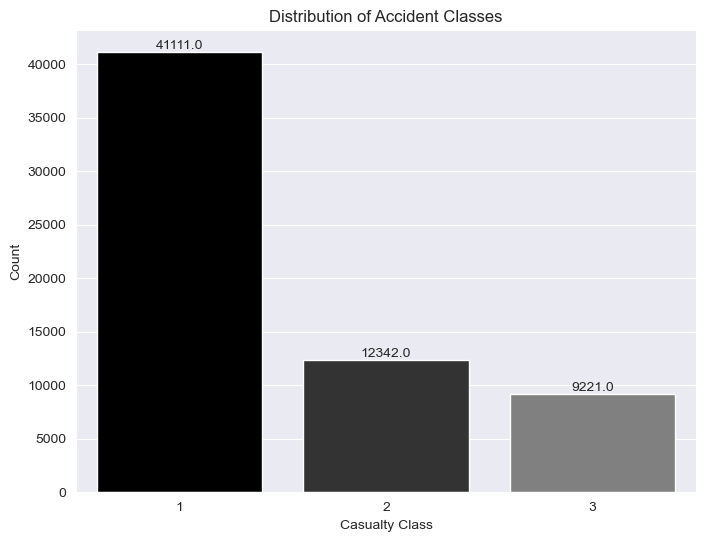

In [11]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='casualty_class', data=road_data, palette=['black', '#333333', 'grey'])

plt.title('Distribution of Accident Classes')
plt.xlabel('Casualty Class')
plt.ylabel('Count')

# Add hover effect
def add_hover_effect(bar, data):
    for rect in bar.patches:
        bar_value = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, bar_value, f'{bar_value}', ha='center', va='bottom')

add_hover_effect(ax, road_data)

plt.show()

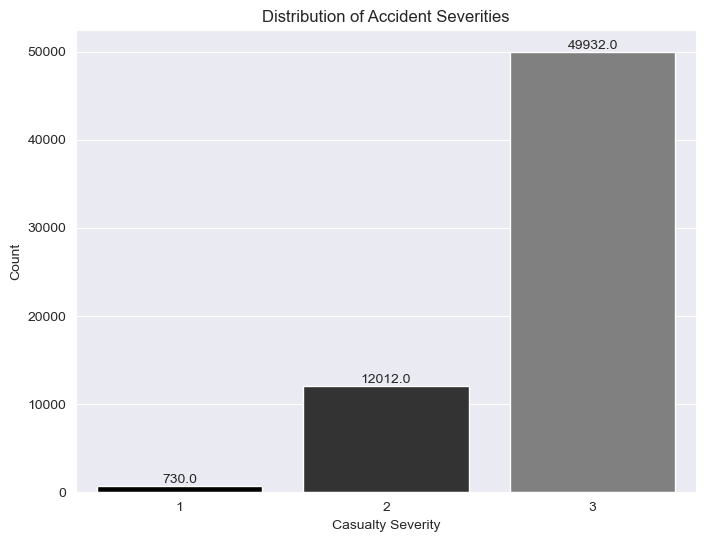

In [12]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='casualty_severity', data=road_data, palette=['black', '#333333', 'grey'])

plt.title('Distribution of Accident Severities')
plt.xlabel('Casualty Severity')
plt.ylabel('Count')

# Add hover effect
def add_hover_effect(bar, data):
    for rect in bar.patches:
        bar_value = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, bar_value, f'{bar_value}', ha='center', va='bottom')

add_hover_effect(ax, road_data)

plt.show()

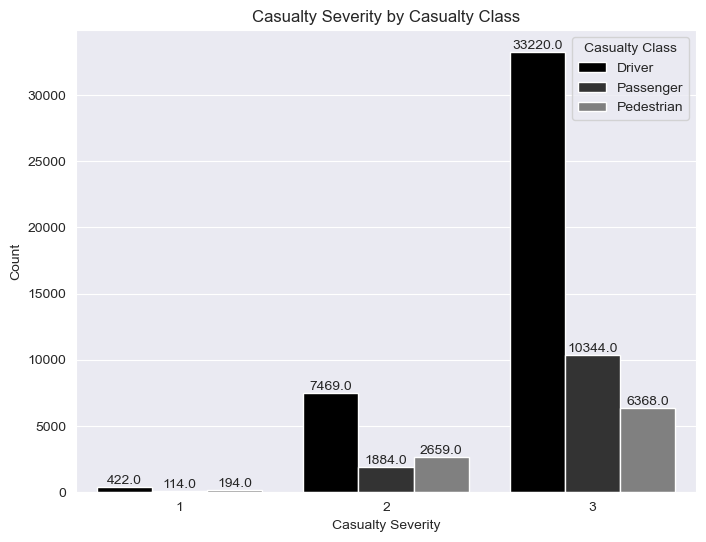

In [13]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='casualty_severity', hue='casualty_class', data=road_data, palette=['black', '#333333', 'grey'])

plt.title('Casualty Severity by Casualty Class')
plt.xlabel('Casualty Severity')
plt.ylabel('Count')
plt.legend(title='Casualty Class', labels=['Driver', 'Passenger', 'Pedestrian'])

# Add hover effect
def add_hover_effect(bar, data):
    for container in bar.containers:
        for rect in container.patches:
            bar_value = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2, bar_value, f'{bar_value}', ha='center', va='bottom')

add_hover_effect(ax, road_data)

plt.show()

Therefore, we observe both target feature may face the issue of class imbalance to have much attention on the majority, especially our target is the minority class here. The issue would require further approaches to be addressed appropriately.
Given that there are only about 700 fatal cases in total and even fewer (194) among pedestrian categories, this indeed present a challenge in terms of credibility of data analysis on fatal outcomes. The limited data could impact the robustness and generalizability of any predictive modelling or deeper machine learning analysis focused solely on fatal outcomes. We would consider the alternative approach:
- Combine serious and fatal levels together
Given the project's focus on pedestrian safety, expanding the severity consideration to include both serious and fatal injuries might be a more balanced approach. Combing the categories could provide a larger sample size compared to only the fatal level. Also, it remains focused on more severe outcomes, which are ofter of greater interest in safety studies. 

### Analysis on Relevant Features

In [14]:
## According to the mentioned relevant features, we make them a list here:
column_names = ['vehicle_reference',
                'casualty_reference',
                'sex_of_casualty',
                'age_of_casualty',
                'pedestrian_location', # categorical
                'pedestrian_movement', # categorical
                'pedestrian_road_maintenance_worker',
                'casualty_imd_decile']

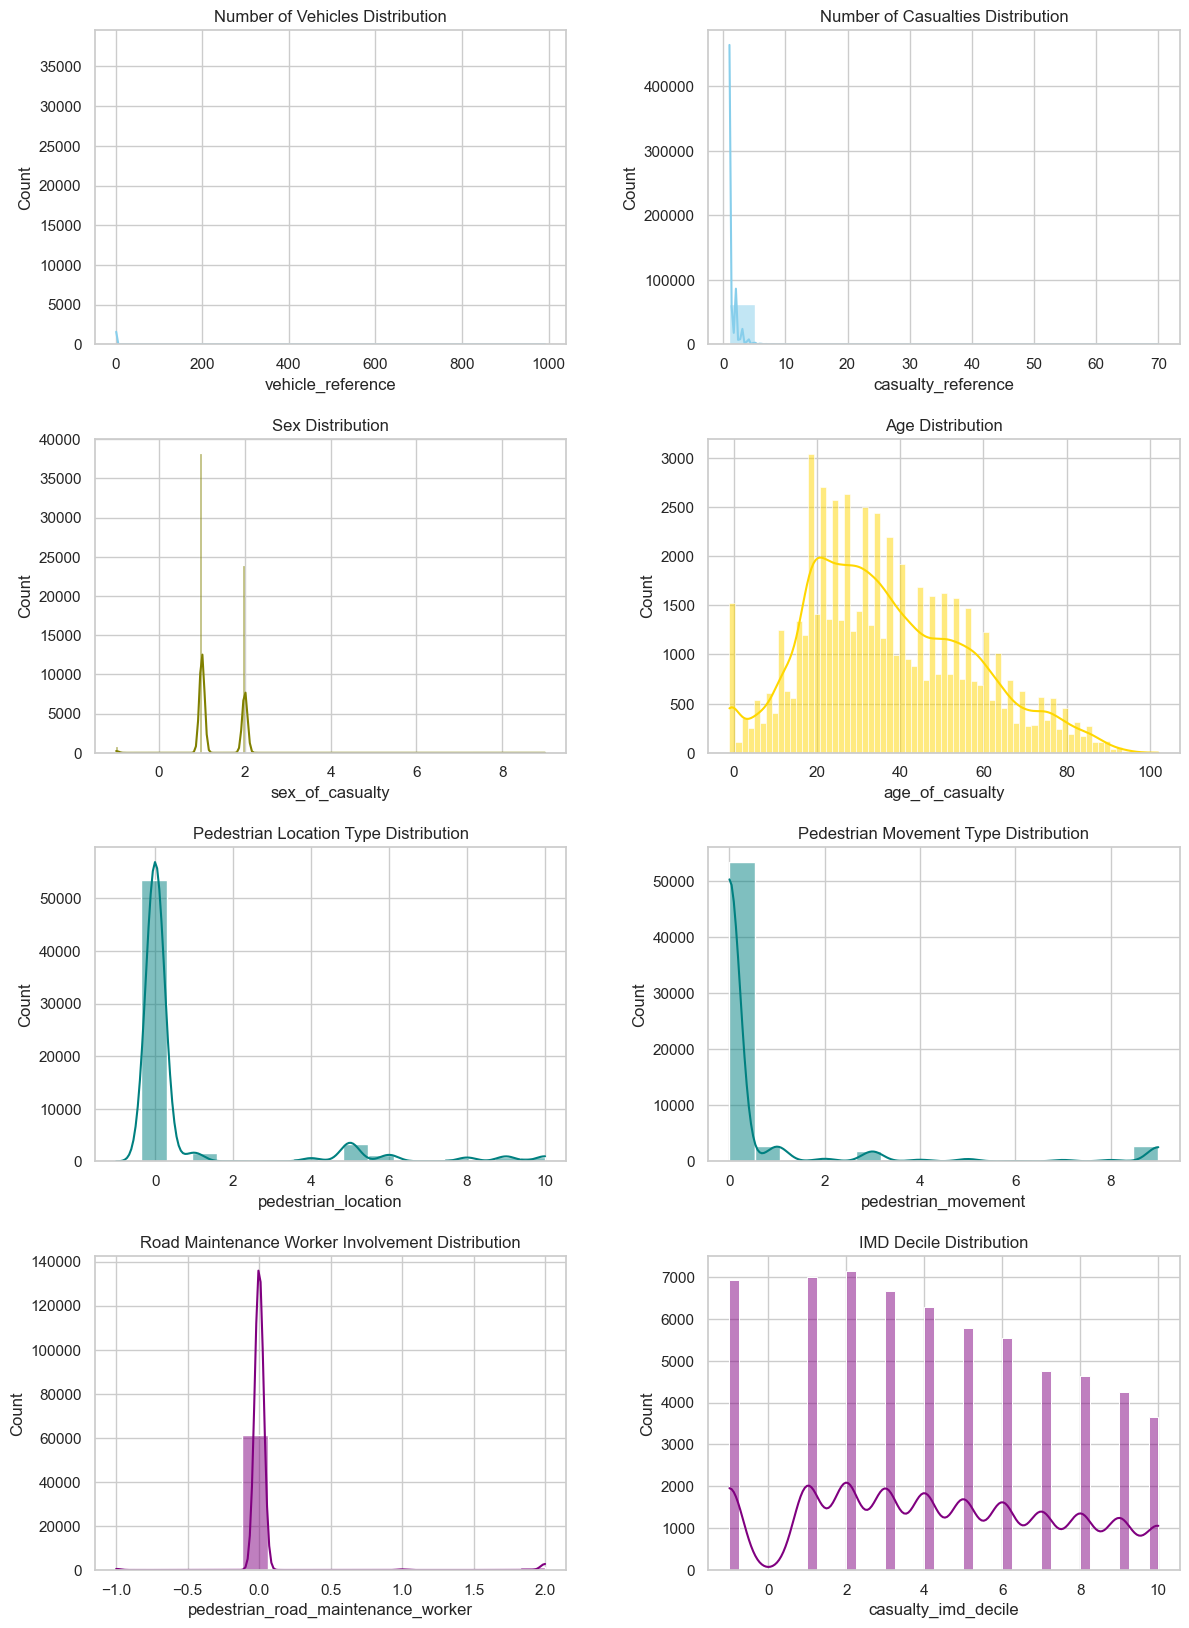

In [15]:

import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating histograms for the numeric variables
fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # Adjust the number of rows to 4 and columns to 2
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Plotting each numeric variable
sns.histplot(road_data['vehicle_reference'], kde=True, ax=axes[0, 0], color='skyblue').set_title('Number of Vehicles Distribution')
sns.histplot(road_data['casualty_reference'], kde=True, ax=axes[0, 1], color='skyblue').set_title('Number of Casualties Distribution')
sns.histplot(road_data['sex_of_casualty'], kde=True, ax=axes[1, 0], color='olive').set_title('Sex Distribution')
sns.histplot(road_data['age_of_casualty'], kde=True, ax=axes[1, 1], color='gold').set_title('Age Distribution')
sns.histplot(road_data['pedestrian_location'], kde=True, ax=axes[2, 0], color='teal').set_title('Pedestrian Location Type Distribution')
sns.histplot(road_data['pedestrian_movement'], kde=True, ax=axes[2, 1], color='teal').set_title('Pedestrian Movement Type Distribution')
sns.histplot(road_data['pedestrian_road_maintenance_worker'], kde=True, ax=axes[3, 0], color='purple').set_title('Road Maintenance Worker Involvement Distribution')
sns.histplot(road_data['casualty_imd_decile'], kde=True, ax=axes[3, 1], color='purple').set_title('IMD Decile Distribution')

plt.show()


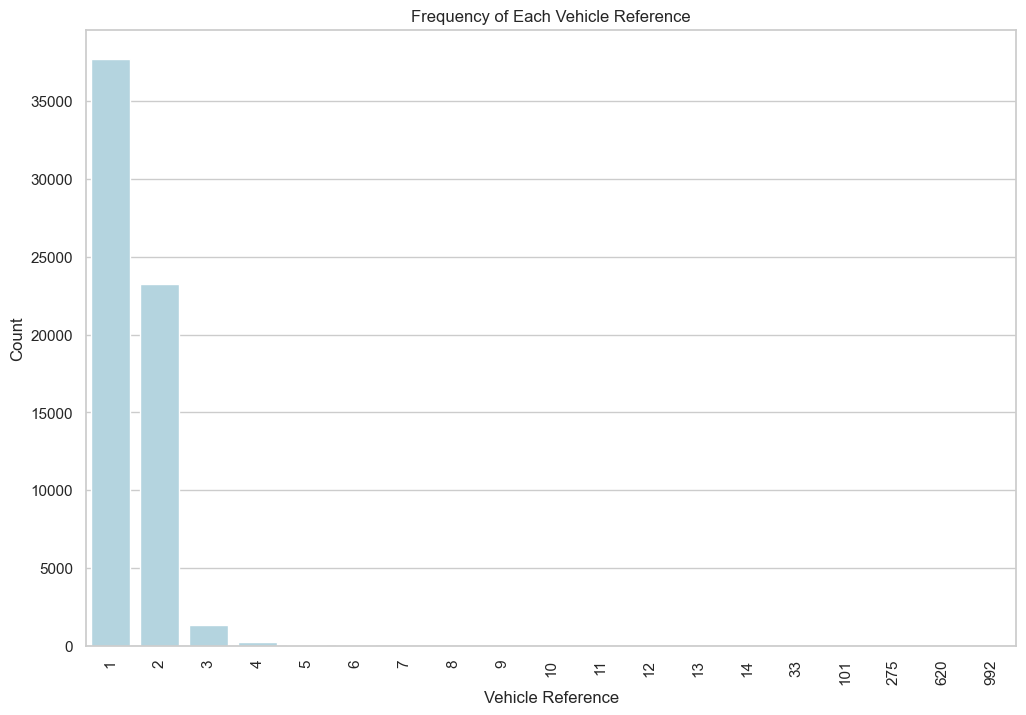

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Calculate the counts for each unique value in 'casualty_reference'
vehicle_counts = road_data['vehicle_reference'].value_counts().reset_index()
vehicle_counts.columns = ['Vehicle Reference', 'Count']

# Create a bar plot for 'casualty_reference' using the 'Set2' palette for more color variety
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Vehicle Reference', y='Count', data=vehicle_counts, color='lightblue')
ax.set_title('Frequency of Each Vehicle Reference')
ax.set_xlabel('Vehicle Reference')
ax.set_ylabel('Count')
plt.xticks(rotation=90)  # Rotate the labels to avoid overlap if necessary
plt.show()



In [4]:
vehicle_reference_counts = road_data['vehicle_reference'].value_counts()

# Filter to find values that occur more than 100 times
vehicle_references_over_100 = vehicle_reference_counts[vehicle_reference_counts > 100]

# Count the number of vehicle references that appear more than 100 times
num_vehicle_references_over_100 = vehicle_references_over_100.count()

# Print the result
print("Number of unique 'vehicle_reference' values occurring more than 100 times:", num_vehicle_references_over_100)

Number of unique 'vehicle_reference' values occurring more than 100 times: 4


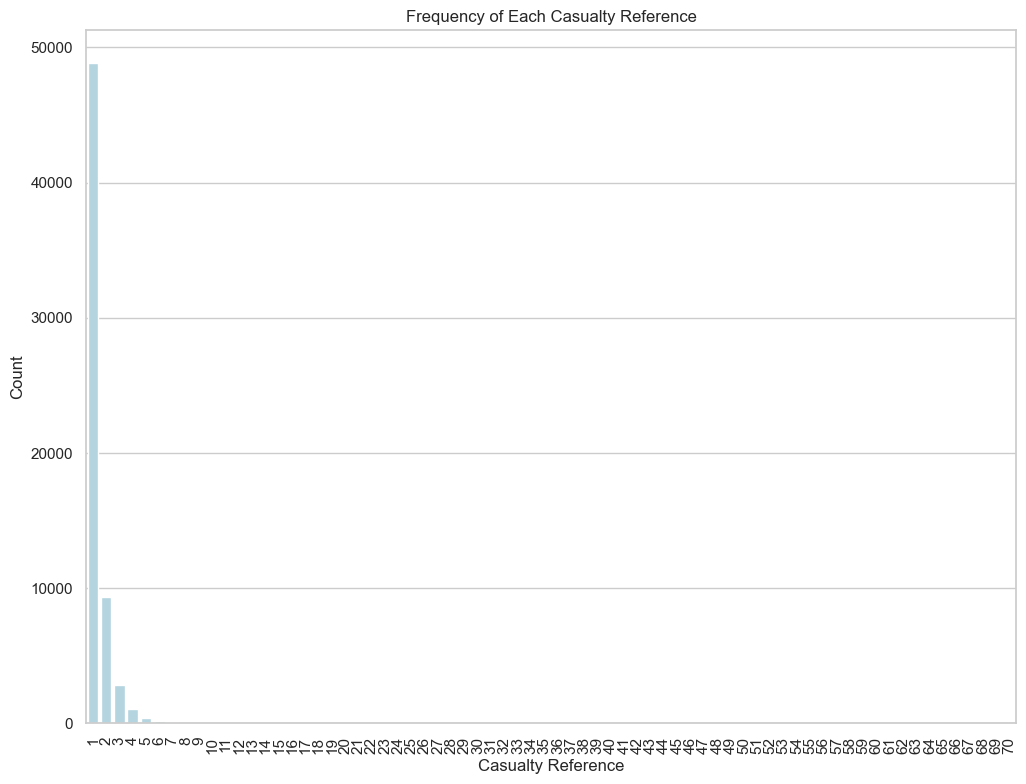

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Calculate the counts for each unique value in 'vehicle_reference'
vehicle_counts = road_data['casualty_reference'].value_counts().reset_index()
vehicle_counts.columns = ['Casualty Reference', 'Count']

# Create a bar plot for 'vehicle_reference'
plt.figure(figsize=(12, 9))
ax = sns.barplot(x='Casualty Reference', y='Count', data=vehicle_counts, color='lightblue')
ax.set_title('Frequency of Each Casualty Reference')
ax.set_xlabel('Casualty Reference')
ax.set_ylabel('Count')
plt.xticks(rotation=90)  # Rotate the labels to avoid overlap if necessary
plt.show()


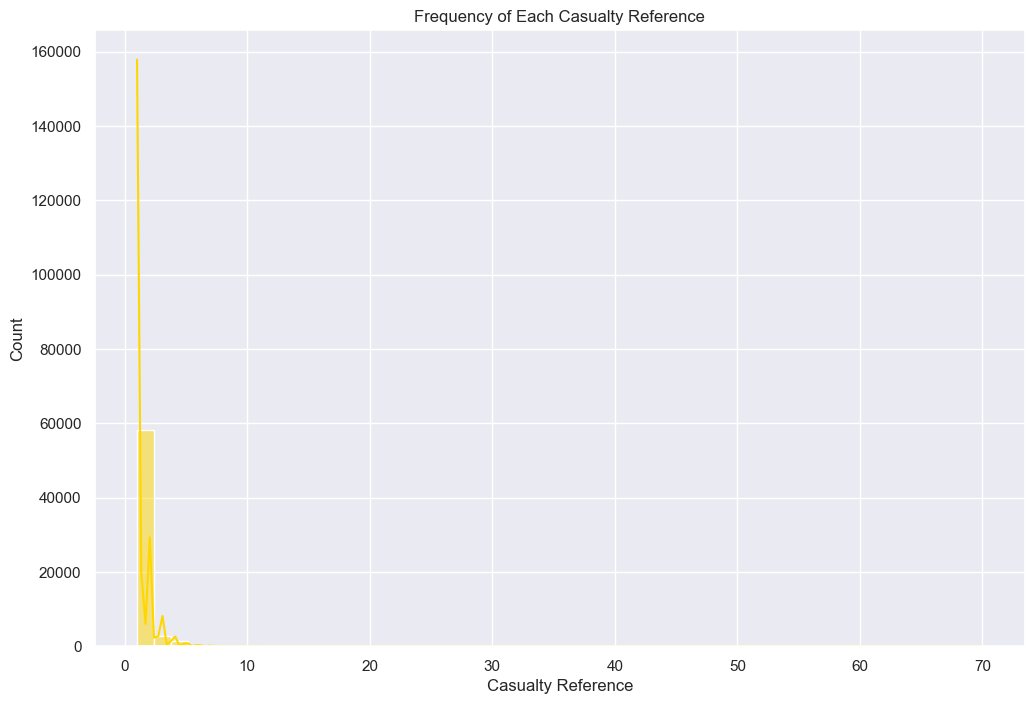

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame `df` with a column `age_of_casualty` that you want to plot
# df = pd.read_csv('your_data.csv') or any other way you have loaded your dataset

# Set the aesthetic style of the plots
sns.set(style="darkgrid")

# Create the histogram with a KDE
plt.figure(figsize=(12, 8))
ax = sns.histplot(road_data['casualty_reference'], bins=50, kde=True, color='gold')
# Set the title and labels
ax.set_title('Frequency of Each Casualty Reference')
ax.set_xlabel('Casualty Reference')
ax.set_ylabel('Count')

# Optional: Set the range of x-axis if you want to focus on a specific age range
# ax.set_xlim(0, 100)

plt.show()


In [17]:
# Summary statistics of numerical columns
road_data.describe().T

,count,mean,std,min,25%,50%,75%,max
collision_year,62674.0,2023.000000,0.000000,2023.0,2023.0,2023.0,2023.0,2023.0
vehicle_reference,62674.0,1.467562,4.849047,1.0,1.0,1.0,2.0,992.0
casualty_reference,62674.0,1.374972,1.551044,1.0,1.0,1.0,1.0,70.0
casualty_class,62674.0,1.491177,0.737688,1.0,1.0,1.0,2.0,3.0
sex_of_casualty,62674.0,1.358107,0.548781,-1.0,1.0,1.0,2.0,9.0
age_of_casualty,62674.0,36.953697,19.805649,-1.0,22.0,34.0,51.0,102.0
age_band_of_casualty,62674.0,6.315410,2.491679,-1.0,5.0,6.0,8.0,11.0
casualty_severity,62674.0,2.785046,0.438231,1.0,3.0,3.0,3.0,3.0
pedestrian_location,62674.0,0.808709,2.208673,-1.0,0.0,0.0,0.0,10.0
pedestrian_movement,62674.0,0.663369,2.041672,0.0,0.0,0.0,0.0,9.0


- Vehicle_reference:

The mean of 1.467562 of$\text{vehicle_reference}$ suggests that on average there is more than one vehicle involved in each collision. Most cases are within 2 vehicles but there are also existence of 3 or 4 vehicles included. The max value of 992 indicates at least one collision involved a large number of vehicles of extreme casualty. 

- Casualty_reference:

Similarly, the mean of 1.37497 of$\text{casualty_reference}$ suggests that on average there is more than one injury involved in each collision. The distribution is highly left-skewed, with a significant number of collisions having a low casualty reference value of 1. There are very few occurrences of collisions with a high casualty reference number of 70 from the statistics summary, suggesting the outliers within this dataset.


- sex_of_casualty

A mean close of sex to 1.4 suggests a slightly higher proportion of male over female.

- age_of_casualty

The distribution appears to be right-skewed, with a higher frequency of relatively younger individuals and gradually fewer counts as age increases. As the age increases, the frequency of individuals decreases, which is typical of many biological populations. The average of casualties is around 37 years old while most people would fall in the age range of 22 to 51 years old.

- pedestrian_location/pedestrian movement

According to the definition of pedestrian locations, the plots suggest that a significant number of collisions happened in carriageway and crossing from driver's nearside, and on pedestrian crossing facility, aligns with the left-skewed distribution. 

- pedestrian_road_maintenance_worker

In most cases, the involvement of pedestrian road maintenance works is not applicable.

- casualty_imd_decile 

 From the plot and definition of feature, a lower decile indicates more deprivation. The graph seems to show a relatively uniform distribution across the deciles, with the first few deciles (indicating higher deprivation) having slightly higher frequencies than the middle deciles. The mean IMD decile is approximately 4.26, which is slightly towards the more deprived end of the spectrum.


The minimum value of several features being -1 should be addressed in data preprocessing as it does not represent a valid interpretation.

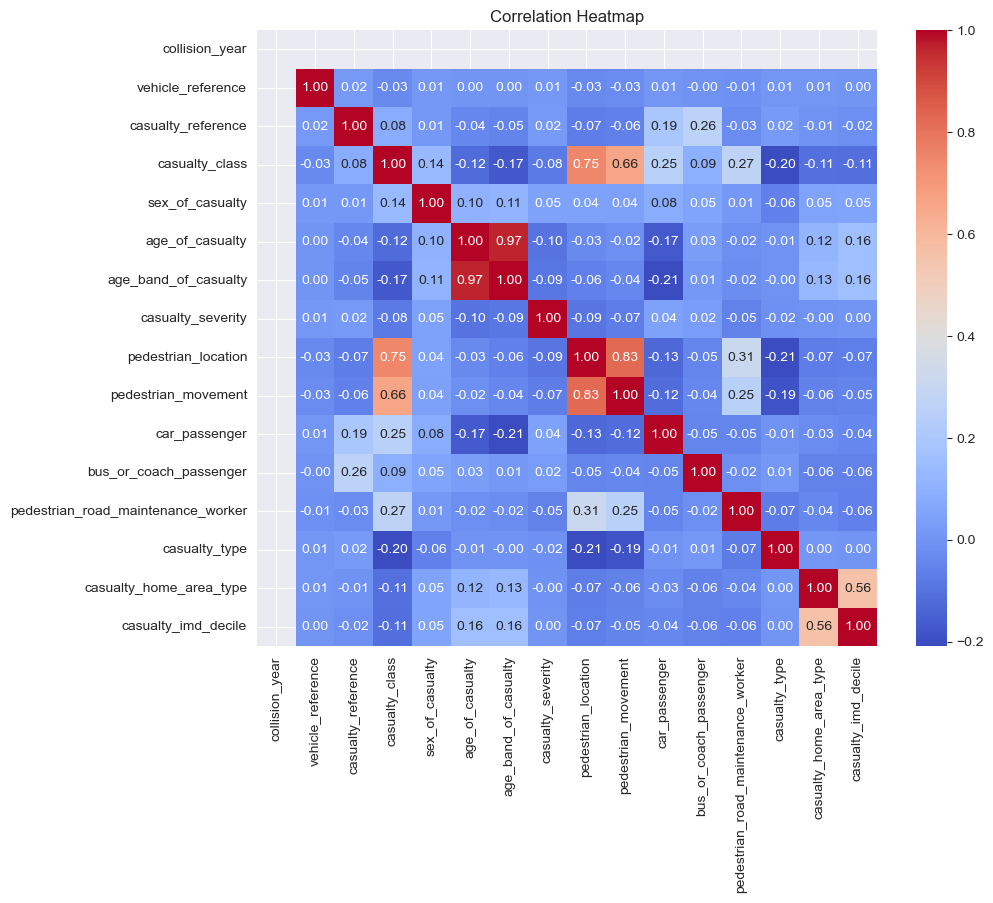

In [19]:
# Heatmap for correlation between numerical variables
numeric_cols = road_data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(road_data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Preprocessing

In [3]:

# Define the columns to impute
columns_to_impute = ['sex_of_casualty', 'age_of_casualty', 'pedestrian_location', 'pedestrian_road_maintenance_worker', 'casualty_imd_decile']

# Impute each column with the median of valid (non -1) values
for column in columns_to_impute:
    # Calculate the median value from non -1 entries
    median_value = road_data[column][road_data[column] != -1].median()
    # Replace -1 with the median value
    road_data[column] = road_data[column].replace(-1, median_value)

filtered_data = road_data[(road_data['vehicle_reference'] <= 100) & (road_data['casualty_reference'] <= 30)]

# Display the shape of the original and filtered datasets to see how many rows were preserved
original_shape = road_data.shape
filtered_shape = filtered_data.shape

# Output the shapes of the original and filtered datasets
print("Original dataset shape:", original_shape)
print("Filtered dataset shape after imputation and removing extreme values:", filtered_shape)


Original dataset shape: (62674, 19)
Filtered dataset shape after imputation and removing extreme values: (62630, 19)


In [29]:
filtered_data.describe().T

,count,mean,std,min,25%,50%,75%,max
collision_year,62630.0,2023.000000,0.000000,2023.0,2023.0,2023.0,2023.0,2023.0
vehicle_reference,62630.0,1.435574,0.633161,1.0,1.0,1.0,2.0,33.0
casualty_reference,62630.0,1.343621,0.883188,1.0,1.0,1.0,1.0,30.0
casualty_class,62630.0,1.490835,0.737802,1.0,1.0,1.0,2.0,3.0
sex_of_casualty,62630.0,1.380552,0.490109,1.0,1.0,1.0,2.0,9.0
age_of_casualty,62630.0,37.767220,18.956299,0.0,23.0,35.0,51.0,102.0
age_band_of_casualty,62630.0,6.315392,2.492266,-1.0,5.0,6.0,8.0,11.0
casualty_severity,62630.0,2.785071,0.438234,1.0,3.0,3.0,3.0,3.0
pedestrian_location,62630.0,0.809277,2.209337,0.0,0.0,0.0,0.0,10.0
pedestrian_movement,62630.0,0.663819,2.042315,0.0,0.0,0.0,0.0,9.0


In [4]:
# Count occurrences of 'pedestrian_location' being 0
count_0 = (filtered_data['pedestrian_location'] == 0).sum()

# Count occurrences of 'pedestrian_location' being 10
count_10 = (filtered_data['pedestrian_location'] == 10).sum()

# Print the results
print("Occurrences of 'pedestrian_location' == 0:", count_0)
print("Occurrences of 'pedestrian_location' == 10:", count_10)


Occurrences of 'pedestrian_location' == 0: 53410
Occurrences of 'pedestrian_location' == 10: 911


In [5]:
# Print out the updated distribution to verify changes
print(filtered_data['pedestrian_location'].value_counts())

0     53410
5      3328
1      1544
6      1164
10      911
9       897
8       688
4       581
7        55
2        35
3        17
Name: pedestrian_location, dtype: int64


In [10]:
# Print out the updated distribution to verify changes
print(filtered_data_new['pedestrian_movement'].value_counts())

0    53410
1     2702
9     2027
3     1822
2      479
5      417
4      305
8      253
7      246
6       58
Name: pedestrian_movement, dtype: int64


In [4]:
# Create a copy of the DataFrame to avoid modifying the original data
filtered_data = filtered_data.copy()

# Shift all values in 'pedestrian_location' upwards by 1 using .loc
filtered_data.loc[:, 'pedestrian_location'] += 1
filtered_data.loc[:, 'pedestrian_movement'] += 1

# Remove entries where 'pedestrian_location' was originally 10 (now 11)
filtered_data_new = filtered_data[filtered_data['pedestrian_location'] <= 10]
filtered_data_new = filtered_data_new[filtered_data_new['pedestrian_movement'] <= 9]

# Check the updated distribution to verify changes
print(filtered_data_new['pedestrian_location'].value_counts())
print(filtered_data_new['pedestrian_movement'].value_counts())

# Display the updated shape of the dataset
updated_shape = filtered_data_new.shape
print("Updated dataset shape:", updated_shape)

1     53410
6      2905
2      1355
10      630
9       615
5       528
7       164
3        34
8        34
4        17
Name: pedestrian_location, dtype: int64
1    53410
2     2702
4     1822
3      479
6      417
5      305
9      253
8      246
7       58
Name: pedestrian_movement, dtype: int64
Updated dataset shape: (59692, 19)


In [5]:
filtered_data_new.describe().T

,count,mean,std,min,25%,50%,75%,max
collision_year,59692.0,2023.000000,0.000000,2023.0,2023.0,2023.0,2023.0,2023.0
vehicle_reference,59692.0,1.455036,0.640169,1.0,1.0,1.0,2.0,33.0
casualty_reference,59692.0,1.354537,0.895131,1.0,1.0,1.0,1.0,30.0
casualty_class,59692.0,1.416555,0.673443,1.0,1.0,1.0,2.0,3.0
sex_of_casualty,59692.0,1.377722,0.489636,1.0,1.0,1.0,2.0,9.0
age_of_casualty,59692.0,37.759046,18.794676,0.0,23.0,35.0,51.0,102.0
age_band_of_casualty,59692.0,6.327012,2.464547,-1.0,5.0,6.0,8.0,11.0
casualty_severity,59692.0,2.788598,0.434659,1.0,3.0,3.0,3.0,3.0
pedestrian_location,59692.0,1.501290,1.666006,1.0,1.0,1.0,1.0,10.0
pedestrian_movement,59692.0,1.276838,1.019817,1.0,1.0,1.0,1.0,9.0


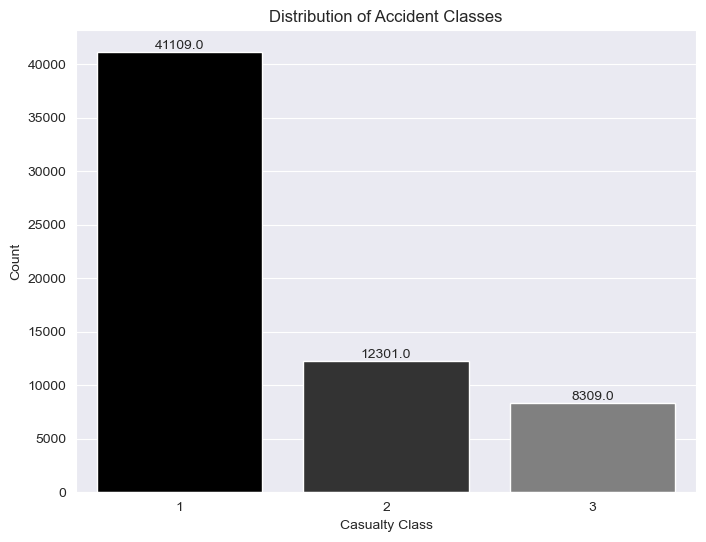

In [7]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='casualty_class', data=filtered_data_new, palette=['black', '#333333', 'grey'])

plt.title('Distribution of Accident Classes')
plt.xlabel('Casualty Class')
plt.ylabel('Count')

# Add hover effect
def add_hover_effect(bar, data):
    for rect in bar.patches:
        bar_value = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, bar_value, f'{bar_value}', ha='center', va='bottom')

add_hover_effect(ax, road_data)

plt.show()

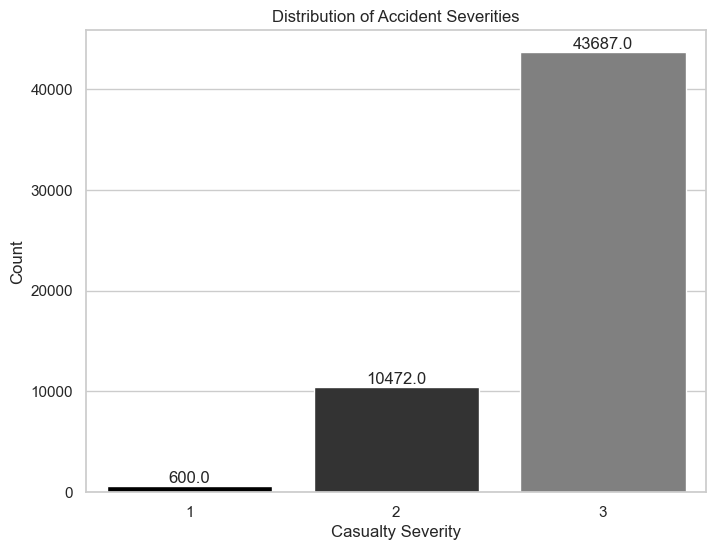

In [51]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='casualty_severity', data=filtered_data, palette=['black', '#333333', 'grey'])

plt.title('Distribution of Accident Severities')
plt.xlabel('Casualty Severity')
plt.ylabel('Count')

# Add hover effect
def add_hover_effect(bar, data):
    for rect in bar.patches:
        bar_value = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, bar_value, f'{bar_value}', ha='center', va='bottom')

add_hover_effect(ax, road_data)

plt.show()

Generate binary variables for both target features:

In [34]:
filtered_data_new = (filtered_data_new.assign(
    casualty_pedestrian=filtered_data_new['casualty_class'].apply(lambda x: 0 if x in [1, 2] else 1),
    casualty_over_serious=filtered_data_new['casualty_severity'].apply(lambda x: 1 if x in [1, 2] else 0)
))

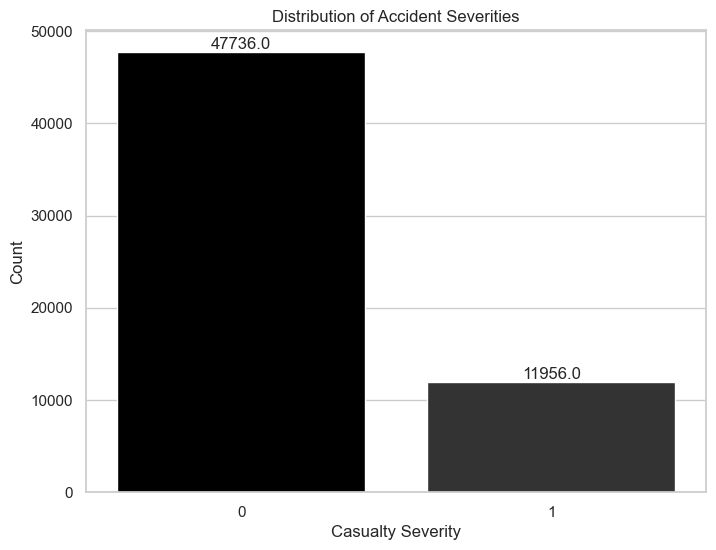

In [35]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='casualty_over_serious', data=filtered_data_new, palette=['black', '#333333', 'grey'])

plt.title('Distribution of Accident Severities')
plt.xlabel('Casualty Severity')
plt.ylabel('Count')

# Add hover effect
def add_hover_effect(bar, data):
    for rect in bar.patches:
        bar_value = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, bar_value, f'{bar_value}', ha='center', va='bottom')

add_hover_effect(ax, road_data)

plt.show()

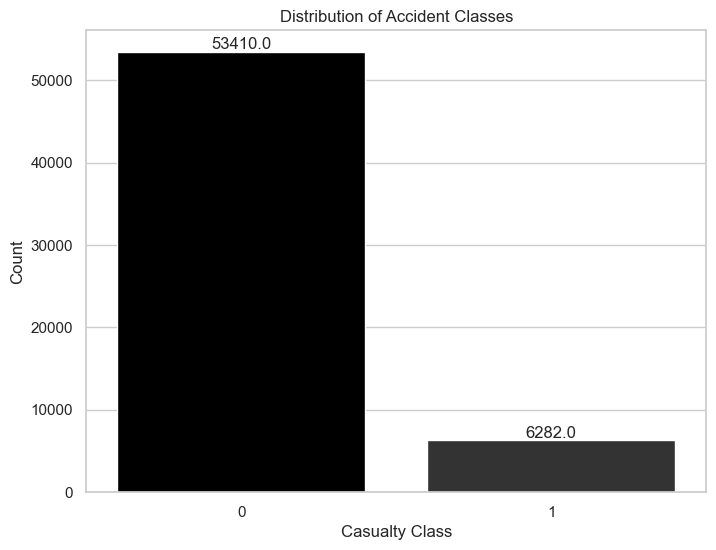

In [36]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='casualty_pedestrian', data=filtered_data_new, palette=['black', '#333333', 'grey'])

plt.title('Distribution of Accident Classes')
plt.xlabel('Casualty Class')
plt.ylabel('Count')

# Add hover effect
def add_hover_effect(bar, data):
    for rect in bar.patches:
        bar_value = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, bar_value, f'{bar_value}', ha='center', va='bottom')

add_hover_effect(ax, road_data)

plt.show()

In [37]:
# Create an interaction term between 'casualty_pedestrian' and 'casualty_over_serious'
filtered_data_new['pedestrian_over_serious'] = filtered_data_new['casualty_pedestrian'] * filtered_data_new['casualty_over_serious']

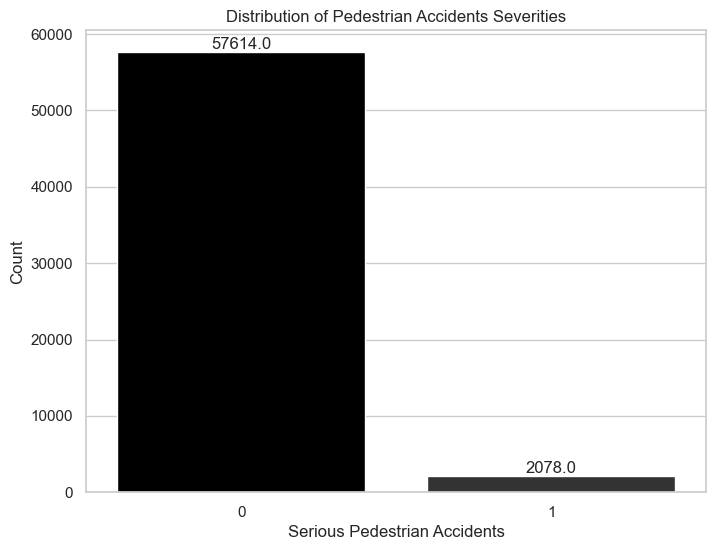

In [38]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='pedestrian_over_serious', data=filtered_data_new, palette=['black', '#333333', 'grey'])

plt.title('Distribution of Pedestrian Accidents Severities')
plt.xlabel('Serious Pedestrian Accidents')
plt.ylabel('Count')

# Add hover effect
def add_hover_effect(bar, data):
    for rect in bar.patches:
        bar_value = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, bar_value, f'{bar_value}', ha='center', va='bottom')

add_hover_effect(ax, road_data)

plt.show()

When dealing with imbalanced data, where the classes have a significant disparity in the number of samples, we would consider some models that can handle imbalanced data more effectively than others. For this project, we intend to use two different classes of models: Random Forest and XGBoost.

Random Forest:

Justification: Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. It is known for its ability to handle imbalanced data relatively well. Random Forest can automatically handle feature interactions, capture complex patterns in the data, and is less sensitive to outliers. Additionally, it can measure feature importance, helping to identify the most relevant features for the prediction task.
Anticipated Issues: If the imbalance is extreme, Random Forest may still favor the majority class, leading to biased predictions. It can also be computationally expensive, especially when dealing with a large number of trees or features. Moreover, the model may overfit if the number of trees is too high or if the trees are allowed to grow too deep.


XGBoost (Gradient Boosting Machines):

Justification: XGBoost is another ensemble learning method that combines weak learners (usually decision trees) to create a strong predictive model. It has gained popularity for its ability to handle imbalanced data effectively. XGBoost can automatically handle missing values and feature interactions, and it has built-in regularization techniques to prevent overfitting. It often provides high predictive accuracy and can handle complex relationships in the data.
Anticipated Issues: Like Random Forest, if the imbalance is extreme, XGBoost may still favor the majority class. It can be sensitive to noisy data and outliers, which may affect the model's performance. Tuning the hyperparameters of XGBoost can be time-consuming and may require expertise.



To further address the issue of imbalanced data, we will employ the following techniques:

Oversampling the minority class or undersampling the majority class to balance the class distribution during model training with technique such as SMOTE.
Using class weights to assign higher weights to the minority class to give it more importance during training.

### 1. Pedestrian Focus

In [64]:
# Set the target feature as 'RainTomorrow'
X = filtered_data_new[['vehicle_reference',
                       'casualty_reference',
                       'sex_of_casualty', 
                       'age_of_casualty',
                       'casualty_imd_decile',
                       ]]
y = filtered_data_new['casualty_pedestrian']


# Perform an 80-20 training-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Address class imbalance in the training set using SMOTE
print('Original dataset shape %s' % Counter(y_train))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check whether the imbalance issue has been addressed
print('Resampled dataset shape %s' % Counter(y_train_smote))

Original dataset shape Counter({0: 42727, 1: 5026})
Resampled dataset shape Counter({0: 42727, 1: 42727})


In [65]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [66]:
# Make predictions
y_pred_pd = rf.predict(X_test)
y_pred_proba_pd = rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate metrics
accuracy_pd = accuracy_score(y_test, y_pred_pd)
roc_auc_pd = roc_auc_score(y_test, y_pred_proba_pd)
report_pd = classification_report(y_test, y_pred_pd)

print(f"ROC AUC: {roc_auc_pd:.5f}")
print(f"Accuracy before Tuning of Pedestrian: {accuracy_pd:.5f}")
print("\n Classification Report before Tuning of Pedestrian:\n", report_pd)

ROC AUC: 0.82118
Accuracy before Tuning of Pedestrian: 0.74202

 Classification Report before Tuning of Pedestrian:
               precision    recall  f1-score   support

           0       0.96      0.75      0.84     10683
           1       0.25      0.71      0.37      1256

    accuracy                           0.74     11939
   macro avg       0.60      0.73      0.60     11939
weighted avg       0.88      0.74      0.79     11939


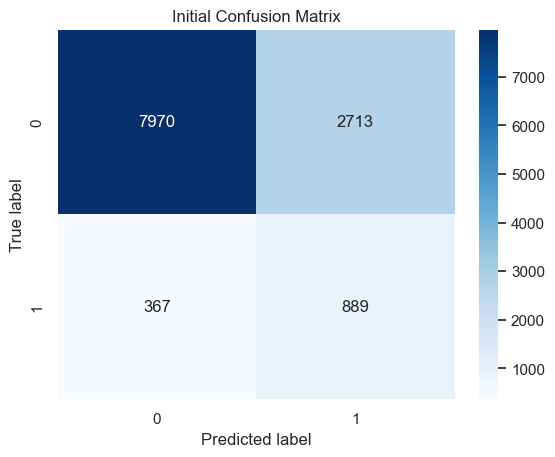

In [67]:
cm_initial_rf= confusion_matrix(y_test, y_pred_pd)
plot_confusion_matrix(cm_initial_rf, classes=['Tomorrow does not rain', 'Tomorrow rains'], title='Initial Confusion Matrix')

In [44]:
# Confusion matrix plotting function
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()